### Purposes of this notebook
This is the second part of the GP Game of Life project. In this notebook, I've saved my runtime analysis and will try to speed up the GP Game of Life

In [10]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from utils import save_model, load_model, save_img
from classes_games import GameOfLife, FakeGameOfLife, Node, FakeGameOfLife9Var, FakeGameOfLife9VarFeature, FasterGameOfLife
torch.random.manual_seed(42)
from time import time

def plot_dist_time(times:tuple, titles:tuple):  
    if len(times) != len(titles):
        raise ValueError("The number of times and titles must be the same!")

    steps = len(times[0])
    for t in times:
        if len(t) != steps:
            raise ValueError("The number of steps must be the same for all times!")
    
    print(f"MEAN TIME (s) FOR STEP FUNCTION ({steps=})")
    for t, title in zip(times, titles):
        print(f"{title}: {np.round(np.mean(t), 5)} +- {np.round(np.std(t), 5)}")

    if len(times) == 2:
        print(f"The true model is {-np.round(100*(np.mean(times[0])-np.mean(times[1]))/np.mean(times[0]), 1)}% faster than the learned one")
    
    for t, title in zip(times, titles):
        plt.hist(t, bins=np.sqrt(steps).astype(np.int16), alpha=0.5, label=title)
    
    plt.yscale('log')
    plt.ylabel("Frequency (log scale)")
    plt.legend()
    plt.title("Distributions of execution time for step function")
    plt.show()

def run_games(games:tuple, steps=1000):
    steps = steps
    time_games = np.zeros((len(games), steps))

    for i, game in enumerate(games):
        for j in range(steps):
            start = time()
            game.step()
            time_games[i, j] = time() - start

    return time_games

### Plain Manual implementation vs GP implementation (SC model 1)

In [11]:
sc = load_model("naive_model1")
torch.manual_seed(42)

gol = GameOfLife(M=20, N=20)
f_gol = FakeGameOfLife(state=gol.state, M=20, N=20, rule=sc)

time_gol, time_f_gol = run_games((gol, f_gol))

MEAN TIME (s) FOR STEP FUNCTION (steps=1000)
True: 0.00055 +- 0.00315
Learned: 0.00438 +- 0.00728
The true model is 702.2% faster than the learned one


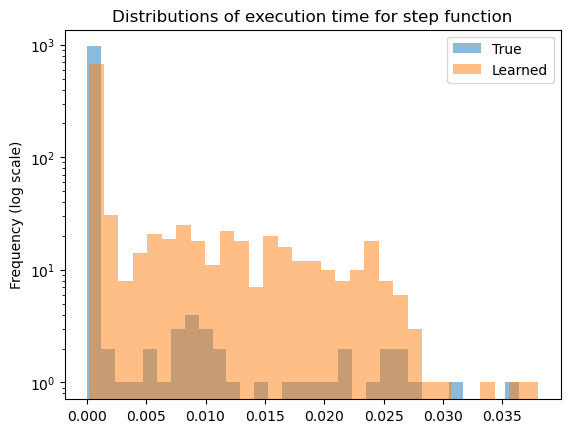

In [12]:
plot_dist_time((time_gol, time_f_gol), ("True", "Learned"))

As we can see, in this case the manual implementation of the rules is faster than the GP implementation.

### Plain Manual implementation vs GP implementation (SC model 2)

In [13]:
st = load_model("Symbolic Transformer 9 to 2")
sc2 = load_model("Symbolic Classifier Model 2")

torch.manual_seed(42)
gol = GameOfLife(M=20, N=20)
f_gol_featurized = FakeGameOfLife9VarFeature(state=gol.state, featurizer=st, rule=sc2)

time_gol, time_f_gol_featurized = run_games((gol, f_gol_featurized))

MEAN TIME (s) FOR STEP FUNCTION (steps=1000)
True: 0.00395 +- 0.00839
Learned: 0.00048 +- 0.00072
The true model is -87.8% faster than the learned one


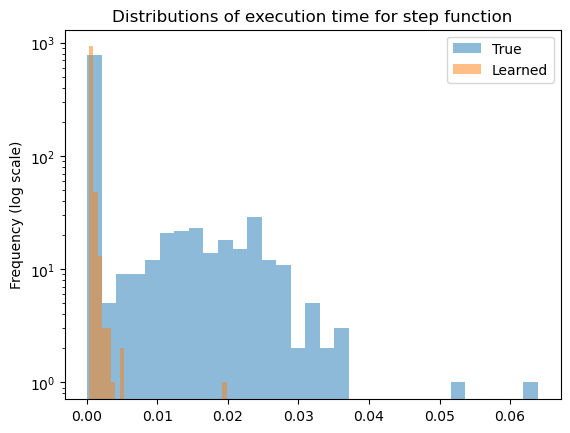

In [14]:
plot_dist_time((time_gol, time_f_gol_featurized), ("True", "Learned"))

Wait, in this case the learned model is 10x faster than the manual implementation. 

This is because I've used a different trick to update each state in the step function (I unpacked the neighbors near each cell and used the vectorized functions)

### Fair Match: Faster Manual Implementation vs GP implementation (SC model 2)

In [15]:
torch.manual_seed(42)
faster_gol = FasterGameOfLife(M=20, N=20)
f_gol_featurized = FakeGameOfLife9VarFeature(state=gol.state, featurizer=st, rule=sc2)

time_faster_gol, time_f_gol_featurized = run_games((faster_gol, f_gol_featurized))

MEAN TIME (s) FOR STEP FUNCTION (steps=1000)
True: 6e-05 +- 3e-05
Learned: 0.00039 +- 0.00033
The true model is 522.3% faster than the learned one


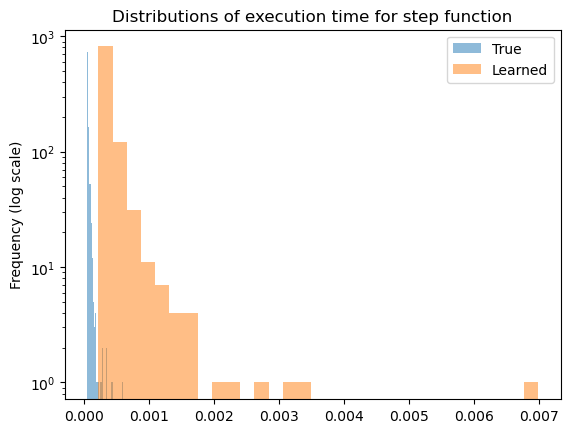

In [16]:
plot_dist_time((time_faster_gol, time_f_gol_featurized), ("True", "Learned"))

Now that I've applied the same trick to both models, we can see that the GP implementation and the manual implementation are almost the same speed.

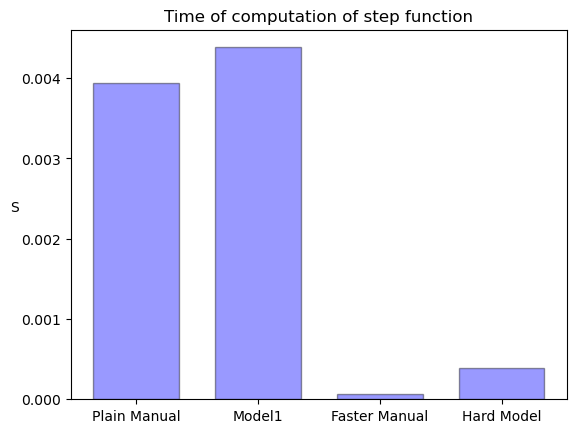

In [17]:
times = np.array([time_gol, time_f_gol, time_faster_gol, time_f_gol_featurized])
performances = np.mean(times, axis=1)
plt.bar(['Plain Manual', 'Model1', 'Faster Manual', 'Hard Model'], performances, color="blue", alpha=0.4, width=0.7, edgecolor="k", linewidth=1)
plt.title("Time of computation of step function")
plt.ylabel("S", rotation=0, labelpad=5)
plt.show()

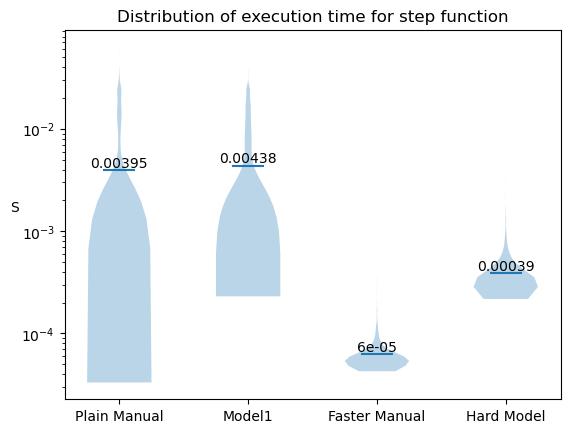

In [18]:
# make a violin plot of the distribution of execution time
plt.violinplot([time_gol, time_f_gol, time_faster_gol, time_f_gol_featurized], showmeans=True, showmedians=False, showextrema=False)
plt.yscale('log')
# format the means in the plot
for i, mean in enumerate([np.mean(time_gol), np.mean(time_f_gol), np.mean(time_faster_gol), np.mean(time_f_gol_featurized)]):
    plt.text(i+1, mean, f"{np.round(mean, 5)}", horizontalalignment='center', verticalalignment='bottom', color='k')


plt.xticks([1, 2, 3, 4], ['Plain Manual', 'Model1', 'Faster Manual', 'Hard Model'])
plt.title("Distribution of execution time for step function")
plt.ylabel("S", rotation=0, labelpad=5)
plt.show()